In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
import multiprocessing as mp

sns.set()

## Task 1 - AES devices

### a/
Interm of power, the parralel 16 S-boxes is sure to drawn in more power (as it needed to perform more computation within a cycle), and thus also have higher noise

### b/
I assume the noise in the parallel case will esclipse over any meaningful data points, making it harder to do an attack

### c/
We can create plaintext that always repeat the same bits in order to make devices B perform the same calculation on all 16 S-boxes and average them to eliminate the noise

## Task 2 - SNR

In [3]:
PATH_PLAINTEXT = './textin_attack.npy'
PATH_TRACES = './traces_attack_int16.npy'
PATH_CIPHERTEXT = './textout_attack.npy'

plaintxt_data = np.load(PATH_PLAINTEXT)
trace_data = np.load(PATH_TRACES)
cipher_data = np.load(PATH_CIPHERTEXT)

In [4]:
#trace[plaintext == 0x00]
firstbyte_index = np.where(plaintxt_data[:, 0] == 0)
filter_traces = trace_data[firstbyte_index]
vertical_means = np.nanmean(filter_traces,axis=0)

In [5]:
firstbyte_index = np.where(plaintxt_data[:, 0] == 0)
filter_traces = trace_data[firstbyte_index]
vertical_vars = np.nanvar(filter_traces,axis=0)

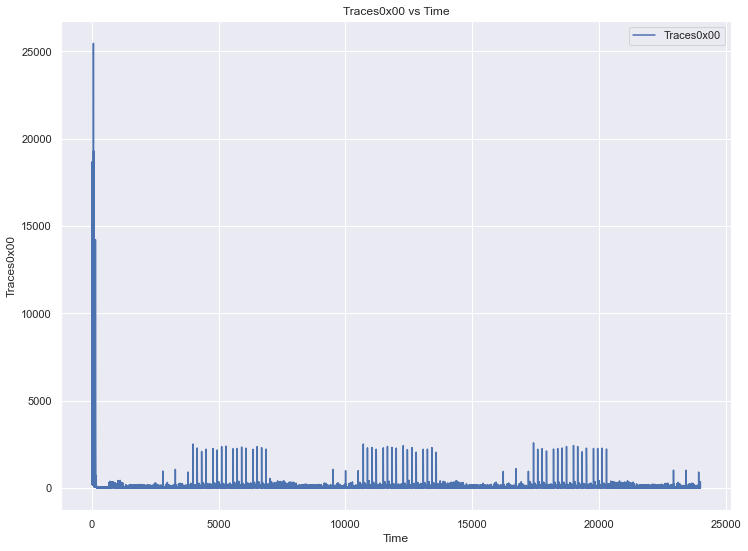

In [6]:
plt.subplots(figsize=(12, 9))
plt.title("Traces0x00 vs Time")
ax = sns.lineplot(x = list(range(24000)), y = vertical_vars, label='Traces0x00')
ax.set(xlabel='Time', ylabel='Traces0x00')
ax.legend()
plt.show()

### a. Create SNR for plaintext input

In [7]:
mean_traces_array = np.zeros([256,24000],dtype=float)
for byte in range(256):
    firstbyte_index = np.where(plaintxt_data[:, 0] == byte)
    filter_traces = trace_data[firstbyte_index]
    vertical_means = np.nanmean(filter_traces,axis=0)
    mean_traces_array[byte] = vertical_means
signal = np.nanvar(mean_traces_array,axis=0)

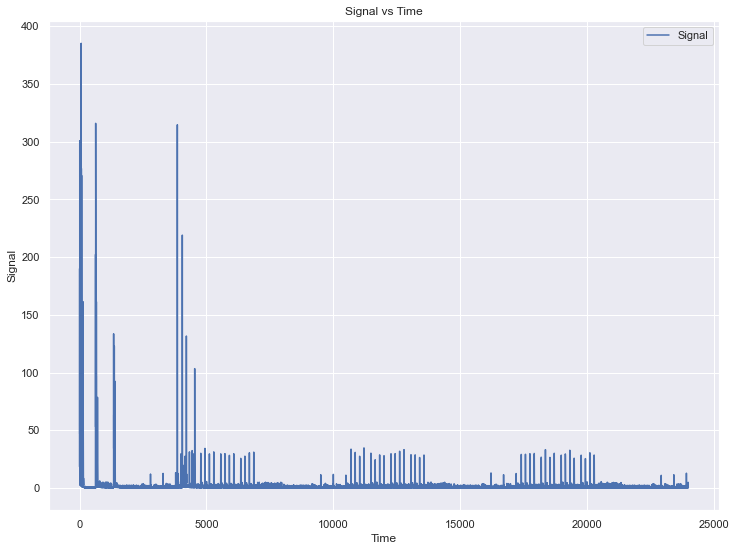

In [8]:
plt.subplots(figsize=(12, 9))
plt.title("Signal vs Time")
ax = sns.lineplot(x = list(range(24000)), y = signal, label='Signal')
ax.set(xlabel='Time', ylabel='Signal')
ax.legend()
plt.show()

In [9]:
var_traces_array = np.zeros([256,24000],dtype=float)
for byte in range(256):
    firstbyte_index = np.where(plaintxt_data[:, 0] == byte)
    filter_traces = trace_data[firstbyte_index]
    vertical_vars = np.nanvar(filter_traces,axis=0)
    var_traces_array[byte] = vertical_vars
noise = np.nanmean(var_traces_array,axis=0)

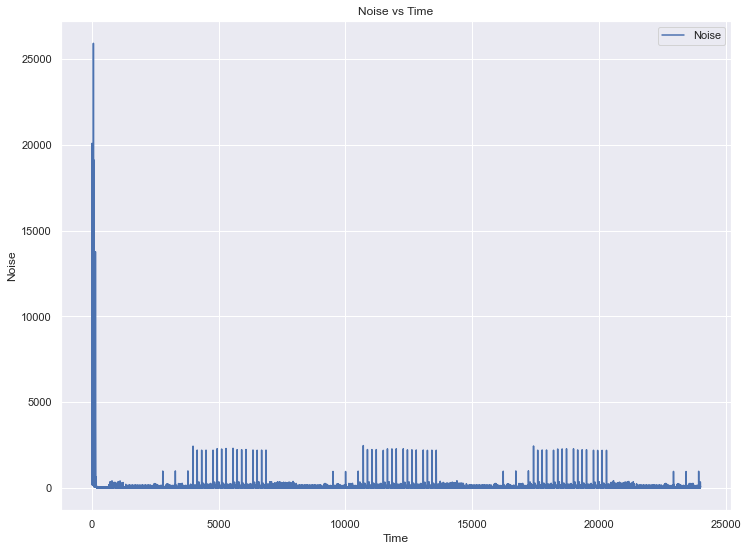

In [10]:
plt.subplots(figsize=(12, 9))
plt.title("Noise vs Time")
ax = sns.lineplot(x = list(range(24000)), y = noise, label='Noise')
ax.set(xlabel='Time', ylabel='Noise')
ax.legend()
plt.show()

In [11]:
snr = np.divide(signal,noise)

<ipython-input-11-491b865be66f>:1: RuntimeWarning: invalid value encountered in true_divide
  snr = np.divide(signal,noise)


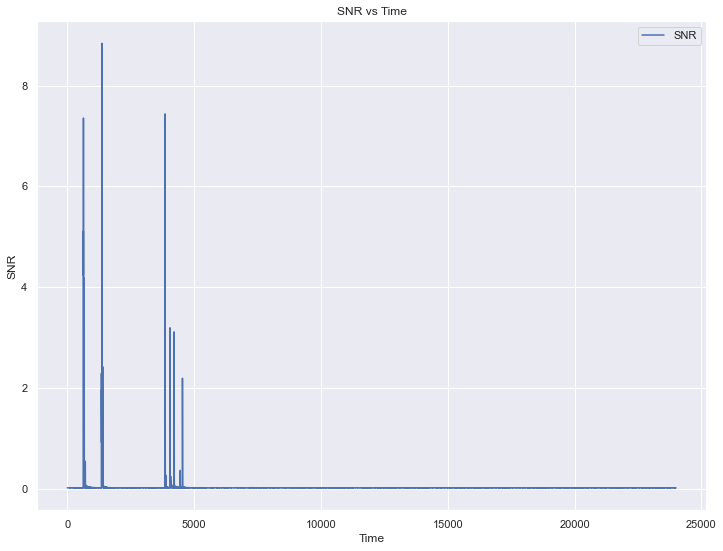

In [12]:
plt.subplots(figsize=(12, 9))
plt.title("SNR vs Time")
ax = sns.lineplot(x = list(range(24000)), y = snr, label='SNR')
ax.set(xlabel='Time', ylabel='SNR')
ax.legend()
plt.show()

In [13]:
np.where(snr > 6)

(array([ 637,  638,  639,  640, 1372, 3857, 3858, 3859], dtype=int64),)

Let's narrow down the range so we can take a closer look at the interesting part:

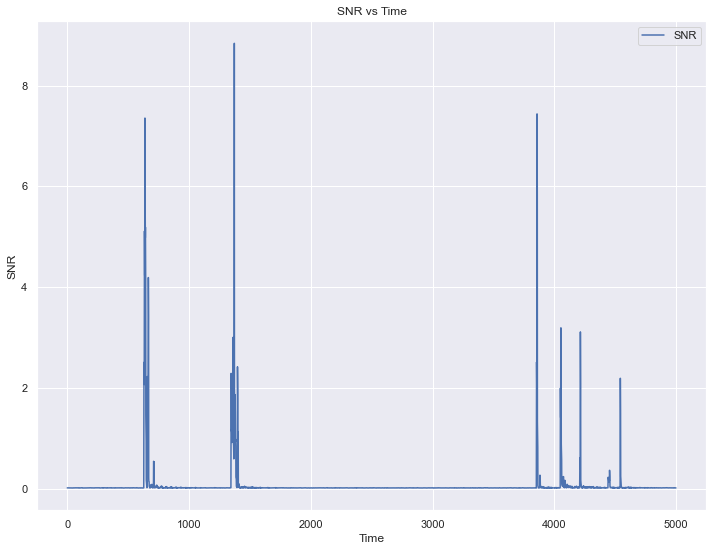

In [14]:
plt.subplots(figsize=(12, 9))
plt.title("SNR vs Time")
ax = sns.lineplot(x = list(range(5000)), y = snr[:5000], label='SNR')
ax.set(xlabel='Time', ylabel='SNR')
ax.legend()
plt.show()

### b. Histogram

select all traces where HW(plaintext) == 0

select of these traces the point in time as identified by the SNR

for this point you create the histogram

#################################

select all traces where HW(plaintext) == 1

select of these traces the point in time as identified by the SNR

for this point you create the histogram

#################################

and so on

In [15]:
sbox = np.array([
        0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
        0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
        0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
        0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
        0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
        0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b, 0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
        0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
        0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
        0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
        0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
        0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
        0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
        0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
        0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
        0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
        0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16
])

def countSetBits(n):
    count = 0
    while (n):
        count += n & 1
        n >>= 1
    return count

hamming_weight_sbox = np.array(list(map(countSetBits, sbox)))


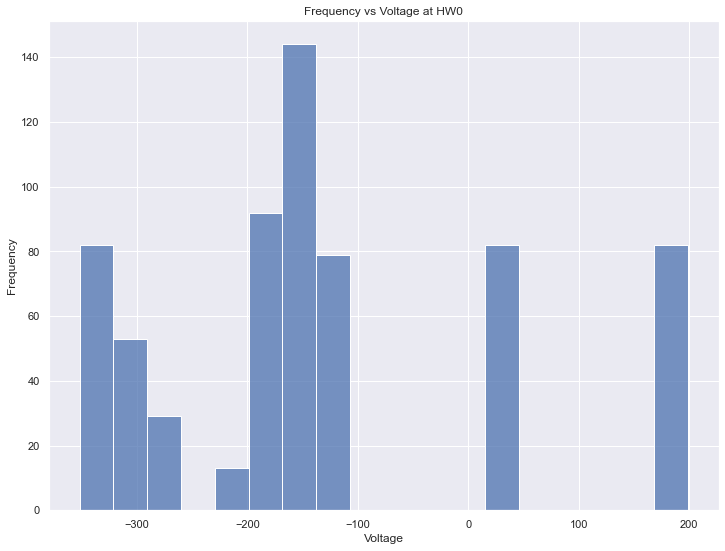

In [16]:
#get all traces where HW(plaintext_firstbit) == 0
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==0)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW0")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

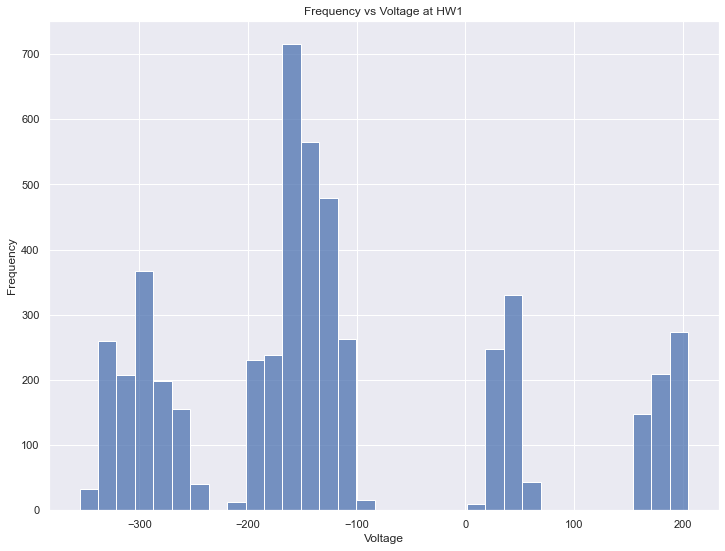

In [17]:
#get all traces where HW(plaintext_firstbit) == 1
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==1)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW1")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

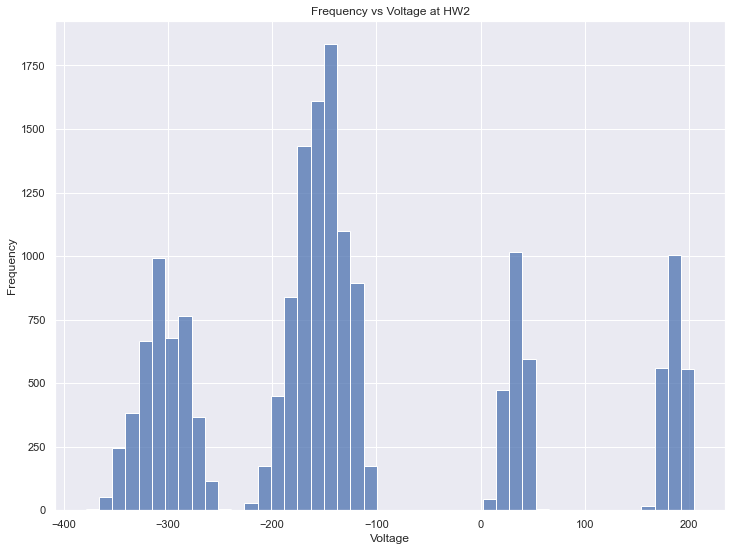

In [18]:
#get all traces where HW(plaintext_firstbit) == 2
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==2)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW2")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

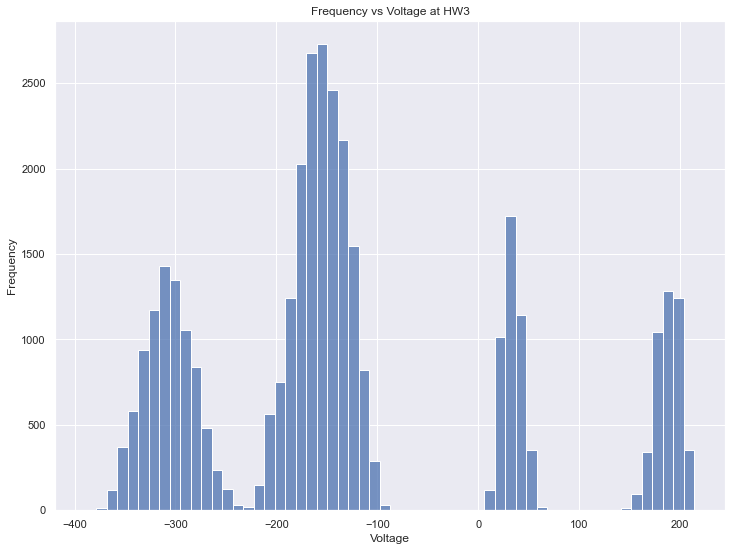

In [19]:
#get all traces where HW(plaintext_firstbit) == 3
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==3)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW3")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

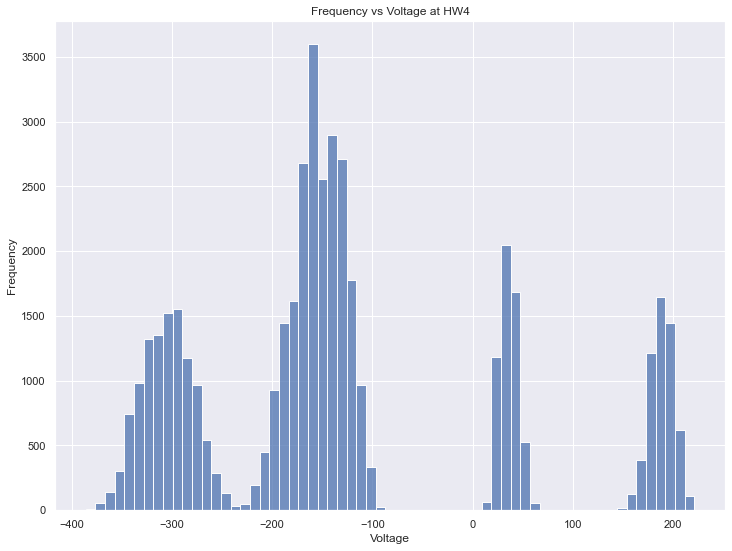

In [20]:
#get all traces where HW(plaintext_firstbit) == 4
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==4)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW4")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

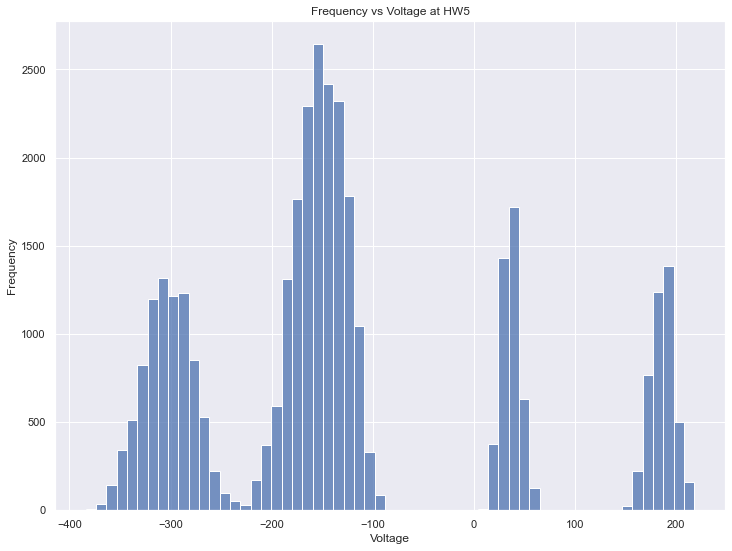

In [21]:
#get all traces where HW(plaintext_firstbit) == 5
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==5)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW5")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

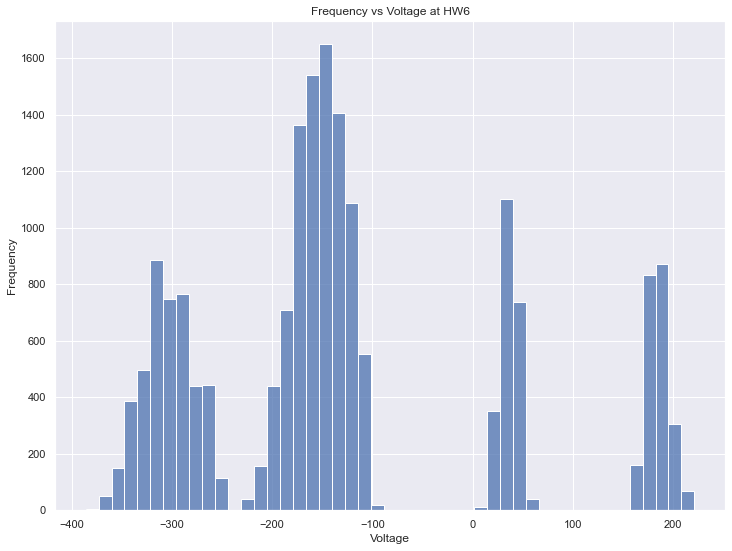

In [22]:
#get all traces where HW(plaintext_firstbit) == 6
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==6)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW6")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

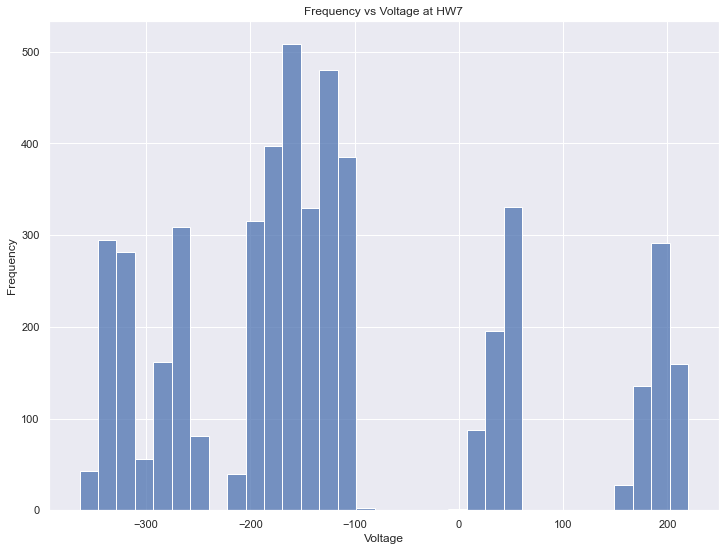

In [23]:
#get all traces where HW(plaintext_firstbit) == 7
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==7)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW7")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

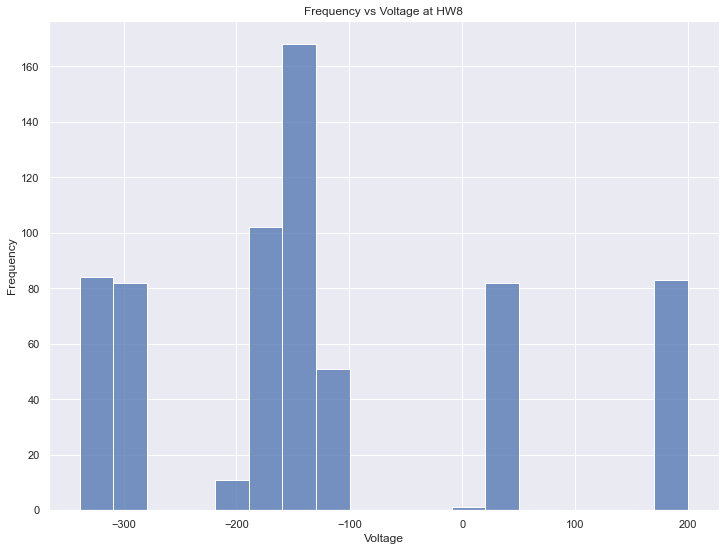

In [24]:
#get all traces where HW(plaintext_firstbit) == 8
traces_index = np.where(hamming_weight_sbox[plaintxt_data[:,0]]==8)
traces_where_hw = trace_data[traces_index]
traces_frequency = traces_where_hw[:,np.where(snr > 6)].flatten()

plt.subplots(figsize=(12, 9))
plt.title("Frequency vs Voltage at HW8")
ax = sns.histplot(x = traces_frequency)
ax.set(xlabel='Voltage', ylabel='Frequency')
plt.show()

### c. Average traces with same input data

See attached image file for annotation, sorry

In [25]:
## get traces where firstbyte input = 0x00:
firstbyte_index = np.where(plaintxt_data[:, 0] == 0)
filter_traces = trace_data[firstbyte_index] 
vertical_means = np.nanmean(filter_traces,axis=0)

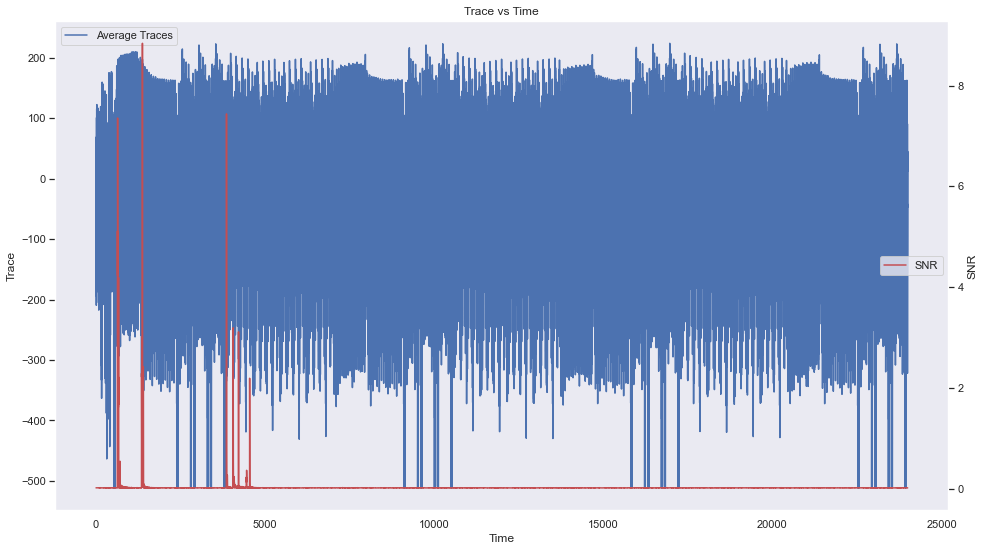

In [26]:
plt.subplots(figsize=(16, 9))
plt.title("Trace vs Time")
ax = sns.lineplot(x = list(range(24000)), y = vertical_means, label='Average Traces')
ax.grid(False)
ax.set(xlabel='Time', ylabel='Trace')
ax2 = plt.twinx()
sns.lineplot(x = list(range(24000)), y = snr, label='SNR', color="r", ax=ax2)
ax2.set(xlabel='Time', ylabel='SNR')
ax2.grid(False)
ax2.legend(loc=5)
ax.legend()
plt.show()

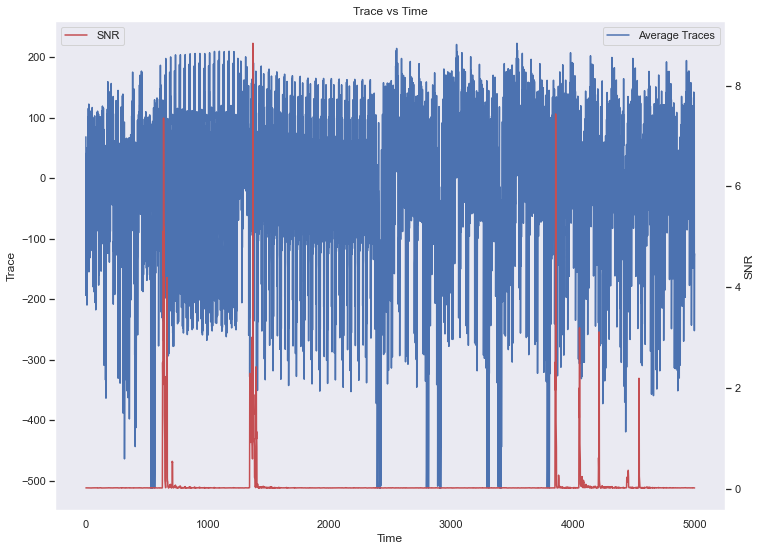

In [27]:
plt.subplots(figsize=(12, 9))
plt.title("Trace vs Time")
ax = sns.lineplot(x = list(range(5000)), y = vertical_means[:5000], label='Average Traces')
ax.grid(False)
ax.set(xlabel='Time', ylabel='Trace')
ax2 = plt.twinx()
sns.lineplot(x = list(range(5000)), y = snr[:5000], label='SNR', color="r", ax=ax2)
ax2.set(xlabel='Time', ylabel='SNR')
ax2.grid(False)
ax2.legend(loc=2)
ax.legend()
plt.show()

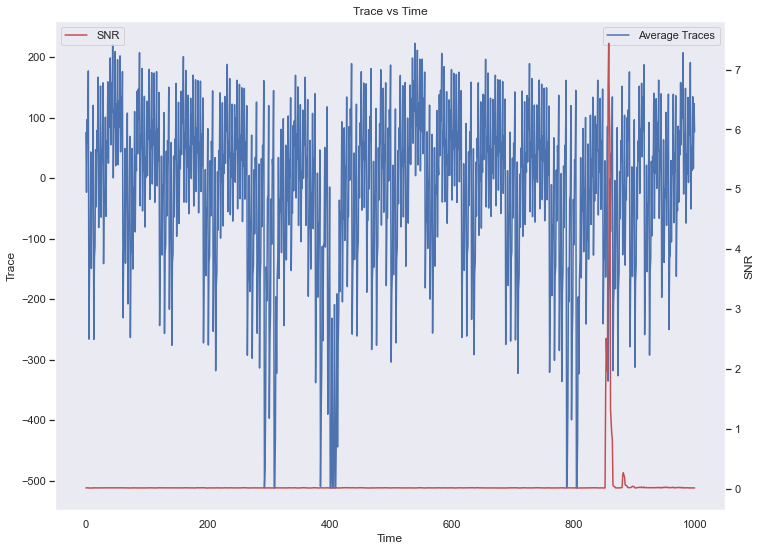

In [28]:
plt.subplots(figsize=(12, 9))
plt.title("Trace vs Time")
ax = sns.lineplot(x = list(range(1000)), y = vertical_means[3000:4000], label='Average Traces')
ax.grid(False)
ax.set(xlabel='Time', ylabel='Trace')
ax2 = plt.twinx()
sns.lineplot(x = list(range(1000)), y = snr[3000:4000], label='SNR', color="r", ax=ax2)
ax2.set(xlabel='Time', ylabel='SNR')
ax2.grid(False)
ax2.legend(loc=2)
ax.legend()
plt.show()

### d. CPA attack

In [29]:
#subset traces range for attacking:
subtrace_data = trace_data[:,1000:2000]

#intermediate values at byte 0:
sbox_Hypothetical = np.zeros([256, 20000])
for i in range(256):
    sbox_Hypothetical[i] = hamming_weight_sbox[np.bitwise_xor(plaintxt_data[:,0],i)]
sbox_Hypothetical = sbox_Hypothetical.T

In [40]:
r = np.zeros([256, subtrace_data.shape[1]])
for t in tqdm(range(subtrace_data.shape[1])):
    traceMean = np.mean(subtrace_data[:, t])
    for k in range(256):
        powerMean = np.mean(sbox_Hypothetical[:, k])
        difPower = sbox_Hypothetical[:, k] - powerMean
        difTrace = subtrace_data[:, t] - traceMean
        nominator = np.sum(np.multiply(difPower, difTrace))
        denominator = np.sqrt(np.sum(np.multiply(difPower, difPower))*np.sum(np.multiply(difTrace,difTrace)))
        if denominator == 0:
            r[k][t] = float("-Inf")
        r[k][t] = nominator / denominator

  0%|          | 0/200 [00:00<?, ?it/s]

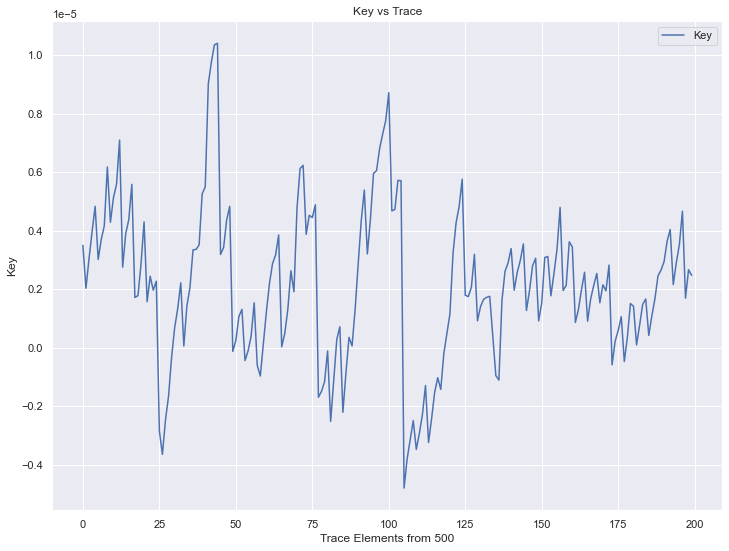

In [57]:
plt.subplots(figsize=(12, 9))
plt.title("Key vs Trace")
ax = sns.lineplot(x = list(range(subtrace_data.shape[1])), y = np.mean(r,axis=0), label='Key')
ax.set(xlabel='Trace Elements from 500', ylabel='Key')
ax.legend()
plt.show()

In [33]:
## GENERALIZED FOR ALL CASED
keybytes = np.zeros(16)
subtrace_data = trace_data[:,1300:1500]
trace_positions = 0
def getCPAkey(b):
    sbox_Hypothetical = np.zeros([256, 20000])
    for i in range(256):
        sbox_Hypothetical[i] = hamming_weight_sbox[np.bitwise_xor(plaintxt_data[:,b],i)]
    sbox_Hypothetical = sbox_Hypothetical.T
    r = np.zeros([256, subtrace_data.shape[1]])
    for t in tqdm(range(subtrace_data.shape[1])):
        traceMean = np.mean(subtrace_data[:, t])
        for k in range(256):
            powerMean = np.mean(sbox_Hypothetical[:, k])
            difPower = sbox_Hypothetical[:, k] - powerMean
            difTrace = subtrace_data[:, t] - traceMean
            nominator = np.sum(np.multiply(difPower, difTrace))
            denominator = np.sqrt(np.sum(np.multiply(difPower, difPower))*np.sum(np.multiply(difTrace,difTrace)))
            r[k][t] = nominator / denominator
    return np.argmax(np.mean(r, axis=1))

def extractKey(method):
    pool = mp.Pool(2)
    keybytes = pool.map(method, list(range(16)))
    pool.close()
    return key

In [ ]:
print(extractKey(getCPAkey))

In [55]:
keybytes

array([108., 127.,  90., 239., 204., 196., 212., 178.,  80., 209.,  33.,
       209., 219., 189., 191., 208.])

Not quite the exact key, but first and last bytes match perfectly. The attack work better when the range of the traces is focus on the peak cluster post the 3500 mark

In [ ]:
correctkey = np.array([[ 43, 126, 21, 207, 79, 60]])

## Task 3 - MIA

In [ ]:
#X denote key hypothesis and Y denoted Traces hypothesis
histogramXs = np.zeros([16,256], dtype = object)
for b in range(16):
    for i in range(256):
        hypothesis = hamming_weight_sbox[np.bitwise_xor(plaintxt_data[:,b],i)]
        #Histogram-based entropy estimation for X[0]:
        weightIndex = list(range(9))
        for w in range(9):
            weightIndex[w] = np.where(hypothesis == w)[0]
        histogramXs[b][i] = [weightIndex, np.unique(hypothesis, return_counts=True)[1]/(hypothesis.shape[0])]

In [ ]:
histogramX = np.array(histogramXs[0][0][1], dtype=float)
plt.subplots(figsize=(12, 9))
plt.title("Frequency of Trace")
axhist = sns.histplot(x = hamming_weight_sbox[np.bitwise_xor(plaintxt_data[:,0],0)], discrete = True)
axpdf = plt.twinx()
sns.lineplot(x = list(range(histogramX.shape[0])), y = histogramX, ax=axpdf)
axpdf.grid(False)
axhist.set(xlabel='Buckets', ylabel='Frequency')
plt.show()

In [ ]:
#Histogram-based entropy estimation for Y:
#subset traces range for attacking:
subtrace_data_mia = trace_data[:,1000:2500]
histogramYs = np.zeros(subtrace_data_mia.shape[1], dtype = object)
for t in tqdm(range(subtrace_data_mia.shape[1])):
    trace = subtrace_data_mia[:, t]
    histogramYs[t] = (np.unique(trace, return_counts=True)[1]/(subtrace_data_mia.shape[0]))

In [ ]:
keys_MIA = np.zeros(16)
keys_MIM = np.zeros(16, dtype = object)
for b in range(16):
    MutualInfo = np.zeros([256, subtrace_data_mia.shape[1]])
    for t in tqdm(range(subtrace_data_mia.shape[1])):
        ProbsY = histogramYs[t]
        EntropyY = np.sum(np.multiply(ProbsY, np.log2(1/ProbsY)))
        for k in range(256):
            ProbsX = histogramXs[b][k][1]
            EntropyTgivenW = np.zeros(9)
            for w in range(9):
                ProbsW = histogramXs[b][k][1][w]
                subT = subtrace_data_mia[histogramXs[b][k][0][w], t]
                ProbsTgivenW = np.divide(np.unique(subT, return_counts=True)[1],subT.shape[0])
                EntropyTgivenW[w] = ProbsW*np.sum(np.multiply(ProbsTgivenW, np.log2(1/ProbsTgivenW)))
            MutualInfo[k][t] = EntropyY - np.sum(EntropyTgivenW)
    trace_positions = np.nanargmax(np.mean(MutualInfo,axis=0))
    key = np.argmax(np.mean(MutualInfo, axis=1))
    keys_MIA[b] = key
    keys_MIM[b] = MutualInfo

In [ ]:
keys_MIA

In [ ]:
correctkey = np.array([[ 43, 126, 21, 207, 79, 60]])

Not quite the key we expected. I suspect this is due to the inaccuracy in Histogram estimation. Materials provided by Chaux et al indicate that the best performance / accuracy ratio can be achieved using b-spline estimation. However, I feel like the calculation step is only fitting when we have a smaller trace range (it seems like the author in this paper use only one trace at peak?). Another points of possible errors are in the final steps when we conclude the key by finding the most likely key hypothesis within the highest average trace. This is done in similar with a CPA attack, and might have overlook some unique aspect of MIA